√âtape 1 : G√©n√©ration de donn√©es synth√©tiques r√©alistes pour le churn

In [1]:
# importation des biblioth√®ques n√©cessaires
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Fixer le seed
np.random.seed(42)
n = 1_000_000

# Distributions des variables
contrats = ['Pr√©pay√©', 'Postpay√©', 'Forfait Illimit√©']
internet_services = ['ADSL', 'Fibre', '4G', 'Aucun']
langues = ['Fran√ßais', 'Arabe', 'Amazigh']
regions = ['Nord', 'Sud', 'Est', 'Ouest', 'Centre']
paiements = ['Carte bancaire', 'Esp√®ces', 'Virement', 'PayPal']
appareils = ['Android', 'iPhone', 'Autre']
operateurs = ['Maroc Telecom', 'Orange', 'Inwi']

# G√©n√©ration du DataFrame
data = pd.DataFrame({
    'contrat': np.random.choice(contrats, n, p=[0.4, 0.4, 0.2]),
    'internet_service': np.random.choice(internet_services, n, p=[0.3, 0.3, 0.3, 0.1]),
    'langue_preferee': np.random.choice(langues, n, p=[0.6, 0.3, 0.1]),
    'region': np.random.choice(regions, n),
    'methode_paiement': np.random.choice(paiements, n),
    'type_appareil': np.random.choice(appareils, n, p=[0.7, 0.25, 0.05]),
    'operateur': np.random.choice(operateurs, n, p=[0.5, 0.3, 0.2]),
    'age': np.random.randint(18, 80, n),
    'revenu': np.random.normal(6000, 1500, n).clip(1000, 20000),
    'anciennete': np.random.exponential(scale=3, size=n).clip(0, 20).round(1)
})

# Cible : churn (simplifi√©e selon des crit√®res heuristiques)
data['churn'] = (
    (data['contrat'] == 'Pr√©pay√©') |
    (data['internet_service'] == 'Aucun') |
    (data['anciennete'] < 1)
).astype(int)

# Aper√ßu rapide
print(data.head())
print(data['churn'].value_counts(normalize=True))

# Sauvegarde √©ventuelle
data.to_csv("synthetic_moroccan_churn_1M.csv", index=False)

            contrat internet_service langue_preferee  region methode_paiement  \
0           Pr√©pay√©            Fibre        Fran√ßais    Nord          Esp√®ces   
1  Forfait Illimit√©            Fibre        Fran√ßais  Centre   Carte bancaire   
2          Postpay√©             ADSL           Arabe  Centre          Esp√®ces   
3          Postpay√©            Fibre        Fran√ßais  Centre   Carte bancaire   
4           Pr√©pay√©               4G        Fran√ßais     Est   Carte bancaire   

  type_appareil      operateur  age       revenu  anciennete  churn  
0        iPhone           Inwi   67  6699.966937         3.2      1  
1        iPhone         Orange   79  5513.948854        13.1      0  
2       Android  Maroc Telecom   75  5368.884532         3.0      0  
3       Android  Maroc Telecom   20  4183.807340         0.9      1  
4       Android         Orange   79  7785.222304         1.8      1  
churn
1    0.606259
0    0.393741
Name: proportion, dtype: float64


√âtape 2 : Pr√©traitement ‚Äî Encodage OneHot et sauvegarde des colonnes utilis√©es

In [2]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Colonnes categorielles 
categorical_cols = [
    'contrat', 'internet_service', 'langue_preferee',
    'methode_paiement', 'operateur', 'region', 'type_appareil'
]

# Encoder OneHot
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Encodage en DataFrame
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=data.index)

# Donn√©es num√©riques + target
numerical_df = data.drop(columns=categorical_cols)
final_df = pd.concat([numerical_df, encoded_df], axis=1)

# Sauvegarde des noms des colonnes (ordre exact utilis√© √† l'entra√Ænement)
feature_names = final_df.drop(columns=['churn']).columns.tolist()
joblib.dump(feature_names, "features.joblib")

# Aper√ßu
print(final_df.shape)
print(final_df.head())


(1000000, 29)
   age       revenu  anciennete  churn  contrat_Forfait Illimit√©  \
0   67  6699.966937         3.2      1                       0.0   
1   79  5513.948854        13.1      0                       1.0   
2   75  5368.884532         3.0      0                       0.0   
3   20  4183.807340         0.9      1                       0.0   
4   79  7785.222304         1.8      1                       0.0   

   contrat_Postpay√©  contrat_Pr√©pay√©  internet_service_4G  \
0               0.0              1.0                  0.0   
1               0.0              0.0                  0.0   
2               1.0              0.0                  0.0   
3               1.0              0.0                  0.0   
4               0.0              1.0                  1.0   

   internet_service_ADSL  internet_service_Aucun  ...  \
0                    0.0                     0.0  ...   
1                    0.0                     0.0  ...   
2                    1.0           

√âtape 3 : R√©duction de dimension par ACP (PCA)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# S√©lection des variables num√©riques (hors churn)
X_numeric = data.select_dtypes(include=[np.number]).drop(columns=["churn"])
y = data["churn"]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# PCA (on conserve 95% de variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Nombre de composantes principales retenues : {pca.n_components_}")


Nombre de composantes principales retenues : 3


√âtape 4 : Visualisation Exploratoire des Composantes Principales (PCA)

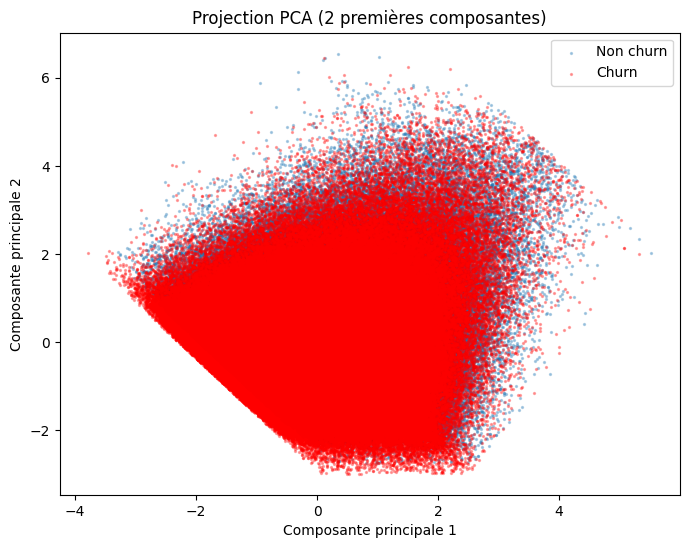

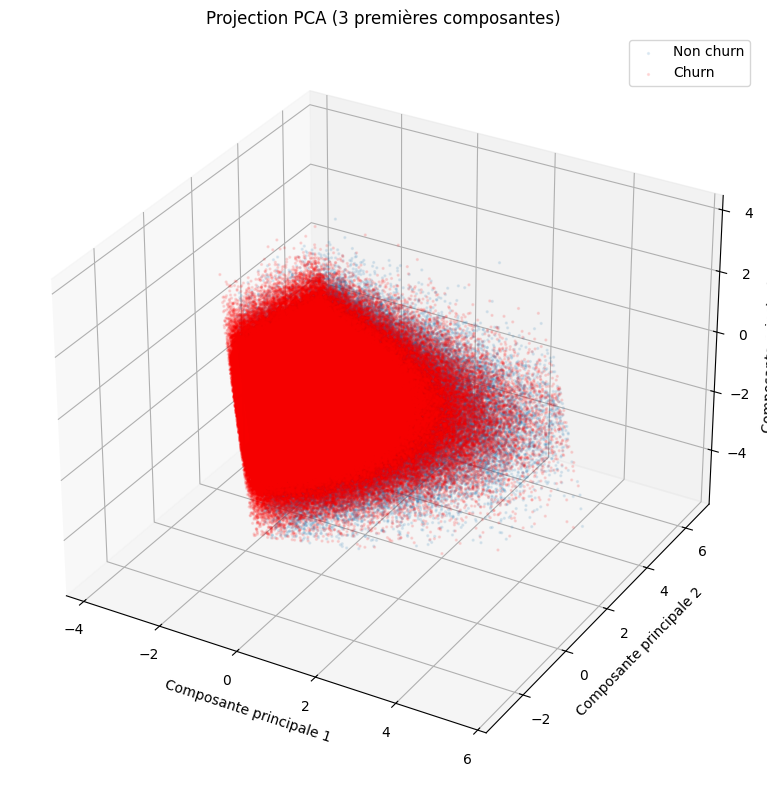

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Visualisation 2D des deux premi√®res composantes principales
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], alpha=0.3, label='Non churn', s=2)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], alpha=0.3, label='Churn', s=2, color='red')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection PCA (2 premi√®res composantes)')
plt.legend()
# Visualisation 3D des trois premi√®res composantes principales

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], X_pca[y == 0, 2], alpha=0.1, label='Non churn', s=2)
ax.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], X_pca[y == 1, 2], alpha=0.1, label='Churn', s=2, color='red')
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
ax.set_title('Projection PCA (3 premi√®res composantes)')
ax.legend()
plt.tight_layout()
plt.show()

√âtape 5 : Entra√Ænement de mod√®les (XGBoost & LightGBM) avec validation crois√©e

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib

# S√©paration des donn√©es
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Initialisation des mod√®les
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)

# Validation crois√©e
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
lgbm_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='roc_auc')

print("\n--- Validation crois√©e ROC AUC ---")
print(f"XGBoost : {xgb_scores.mean():.4f} +/- {xgb_scores.std():.4f}")
print(f"LightGBM : {lgbm_scores.mean():.4f} +/- {lgbm_scores.std():.4f}")

# Entra√Ænement final
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# √âvaluation sur le test set
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
lgbm_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

print("\n--- ROC AUC sur test set ---")
print(f"XGBoost : {roc_auc_score(y_test, xgb_pred_proba):.4f}")
print(f"LightGBM : {roc_auc_score(y_test, lgbm_pred_proba):.4f}")

# Sauvegarde des mod√®les
joblib.dump(xgb_model, "model_xgboost_churn.joblib")
joblib.dump(lgbm_model, "model_lightgbm_churn.joblib")


[LightGBM] [Info] Number of positive: 388006, number of negative: 251994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 388006, number of negative: 251994
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 3
[LightGBM] [Info] 

['model_lightgbm_churn.joblib']

√âtape 6 : √âvaluation des mod√®les avec pr√©cision, rappel, F1-score et matrice de confusion

üîç √âvaluation - XGBoost
              precision    recall  f1-score   support

   Non churn       0.54      0.83      0.65     78748
       Churn       0.83      0.54      0.66    121252

    accuracy                           0.65    200000
   macro avg       0.69      0.69      0.65    200000
weighted avg       0.72      0.65      0.66    200000

üîç √âvaluation - LightGBM
              precision    recall  f1-score   support

   Non churn       0.54      0.90      0.67     78748
       Churn       0.88      0.50      0.64    121252

    accuracy                           0.66    200000
   macro avg       0.71      0.70      0.66    200000
weighted avg       0.75      0.66      0.65    200000



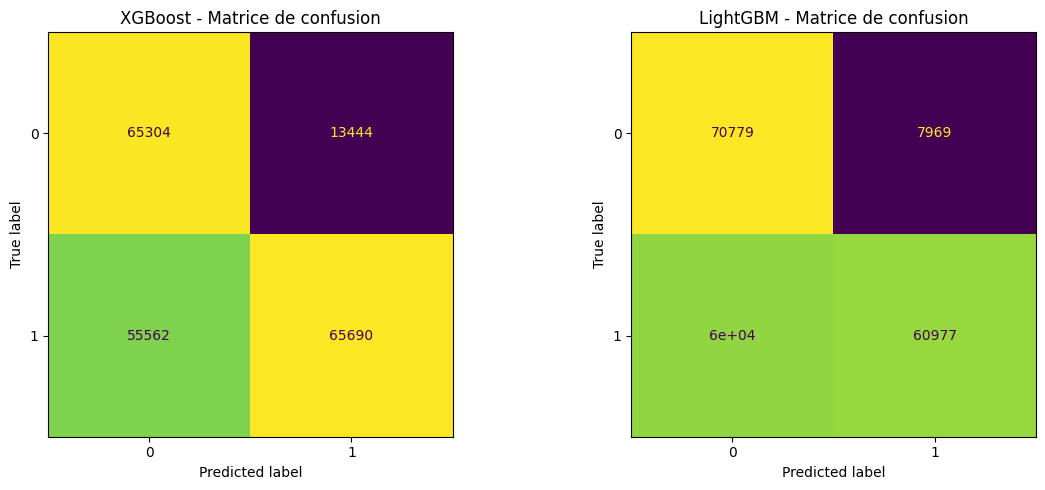

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pr√©dictions sur le set de test
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Affichage des scores
print("üîç √âvaluation - XGBoost")
print(classification_report(y_test, y_pred_xgb, target_names=["Non churn", "Churn"]))

print("üîç √âvaluation - LightGBM")
print(classification_report(y_test, y_pred_lgbm, target_names=["Non churn", "Churn"]))

# Matrices de confusion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, ax=axs[0], colorbar=False)
axs[0].set_title("XGBoost - Matrice de confusion")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm, ax=axs[1], colorbar=False)
axs[1].set_title("LightGBM - Matrice de confusion")

plt.tight_layout()
plt.show()


√âtape 7 : Interpr√©tabilit√© des mod√®les ‚Äî Importance des variables via SHAP et Gain

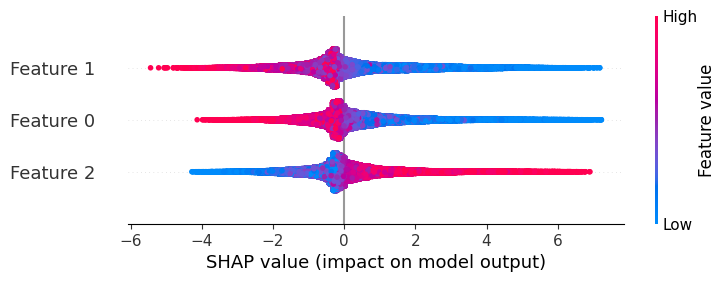

In [7]:
import shap
import matplotlib.pyplot as plt

# Choisir le mod√®le √† expliquer (LightGBM ici)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP summary plot (valeurs de shap les plus impactantes)
shap.plots.beeswarm(shap_values, max_display=20)


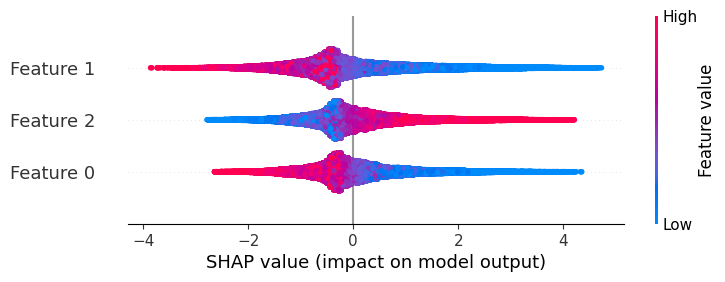

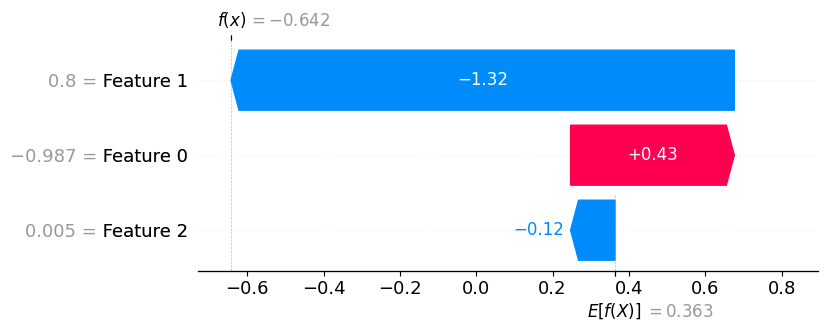

In [8]:
import shap
import matplotlib.pyplot as plt

# Choisir le mod√®le √† expliquer (LightGBM ici)
explainer = shap.Explainer(lgbm_model)
shap_values = explainer(X_test)

# SHAP summary plot (valeurs de shap les plus impactantes)
shap.plots.beeswarm(shap_values, max_display=20)
# SHAP force plot pour une instance sp√©cifique
shap.initjs()       

# SHAP waterfall plot pour une instance sp√©cifique
shap.waterfall_plot(shap_values[0], max_display=20) 


√âtape 8 : Analyse des importances des variables via Permutation Importance

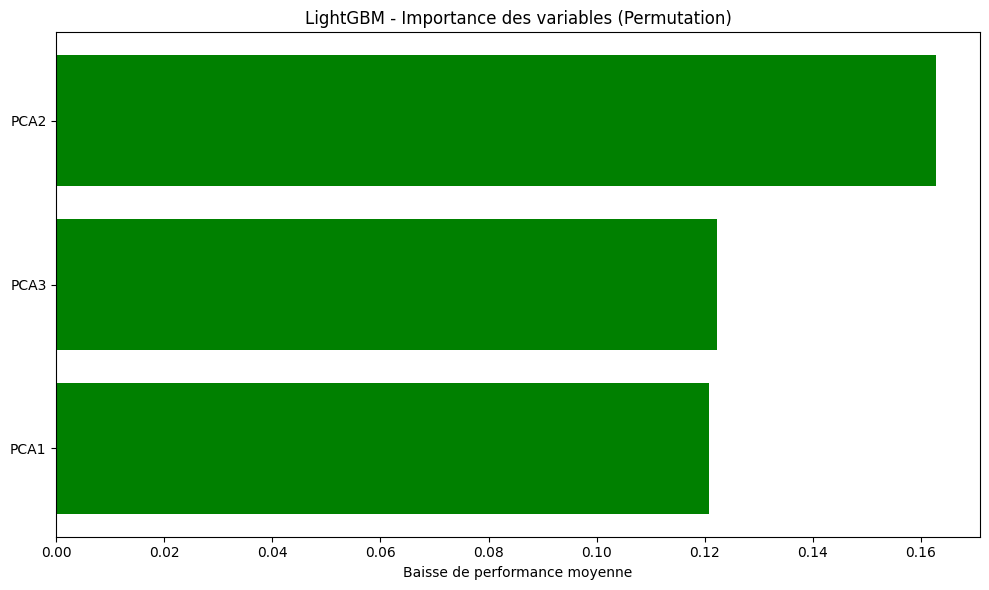

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Pour LightGBM
perm_lgbm = permutation_importance(lgbm_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx_lgbm = perm_lgbm.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_lgbm)), perm_lgbm.importances_mean[sorted_idx_lgbm], align='center', color="green")
plt.yticks(range(len(sorted_idx_lgbm)), np.array(['PCA1', 'PCA2', 'PCA3'])[sorted_idx_lgbm])
plt.title("LightGBM - Importance des variables (Permutation)")
plt.xlabel("Baisse de performance moyenne")
plt.tight_layout()
plt.show()


√âtape 8 : Sauvegarde des artefacts du mod√®le pour l'application

In [11]:
import joblib

# Sauvegarde du mod√®le LightGBM entra√Æn√©
joblib.dump(lgbm_model, "model_lightgbm_churn.joblib")

# Sauvegarde des noms des composantes principales (PCA)
pca_feature_names = [f"PCA{i+1}" for i in range(X_train.shape[1])]
joblib.dump(pca_feature_names, "features.joblib")

# Sauvegarde du scaler utilis√©
joblib.dump(scaler, "scaler_churn.joblib")

# Sauvegarde des colonnes utilis√©es pour le scaler (colonnes num√©riques avant PCA)
joblib.dump(list(X_numeric.columns), "scaler_features.joblib")

print("Mod√®le, scaler et noms de colonnes sauvegard√©s avec succ√®s.")


Mod√®le, scaler et noms de colonnes sauvegard√©s avec succ√®s.


In [12]:
import pandas as pd
import joblib

# Chargement du fichier brut
data = pd.read_csv("synthetic_moroccan_churn_1M.csv")

# Colonnes cat√©gorielles √† encoder
categorical_cols = [
    'contrat', 'internet_service', 'langue_preferee',
    'methode_paiement', 'operateur', 'region', 'type_appareil'
]

# One-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols)

# Sauvegarde de la liste des colonnes (pour le mod√®le)
feature_names = [col for col in data_encoded.columns if col != "churn"]
joblib.dump(feature_names, "features.joblib")

# S√©paration X et y
X = data_encoded[feature_names]
y = data_encoded["churn"]

# Export fichier encod√©
df_export = pd.concat([X, y], axis=1)
df_export.to_csv("data_encoded.csv", index=False)

print("‚úÖ Fichier encod√© sauvegard√© : data_encoded.csv")
print("‚úÖ Noms des colonnes sauvegard√©s dans features.joblib")


‚úÖ Fichier encod√© sauvegard√© : data_encoded.csv
‚úÖ Noms des colonnes sauvegard√©s dans features.joblib
